# LASERBEANS
*Tools for quick data exploration and presentation*
***
This notebook contains some examples for using the **laserbeans** package. We will use fictitious enrollment data to show how to use the different modules and functions. Let's start by importing the necessary packages and data:

In [1]:
import pandas as pd
import laserbeans.tables as tbl
import laserbeans.resamplers as smp
import laserbeans.charts as chrt

df = pd.read_pickle('test_data/enrollment_data.pkl')

### Plotting the number of enrollment request per week for the 2018 academic year
In the example below we plot the number of enrolments per week.
To do so, we first select only the records for the 2018 academic year with the **pandas** `query` method.
Then we use the **laserbeans** `aggregate_time` function from the **tables** module to count the records per week.

- The `grouper_cols` is set to *ENROLLMENT_TYPE* as our category.
- The (time) `unit` is set to 'W' for weeks.
- Finally, setting `use_dt` to `True` returns the weeks as dates instead of week numbers.

Because we want to show the enrollment types in their defined order, we create a list from the ordered categories of the field `ENROLLMENT_TYPE`.
Finally we use the **laserbeans** `generate_chart` function form the **charts** module to create a **vega** stacked bar chart using **altair**.

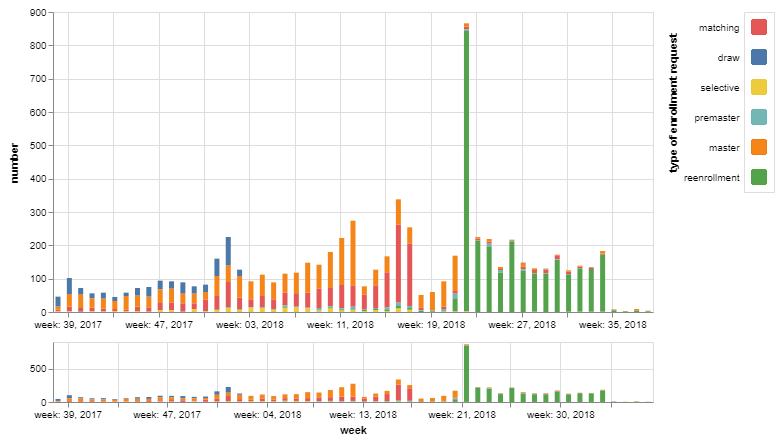

In [2]:
qry = """ACADEMIC_YEAR == 2018"""
df_rpw = tbl.aggregate_time(df.query(qry), 'REQUEST_DATE', grouper_cols='ENROLLMENT_TYPE', 
                            start=(2017, 10, 1), end=(2018, 10, 1), unit='W', use_dt=True)
df_rpw.index.name = 'week'

var_order = df.ENROLLMENT_TYPE.cat.categories.tolist()
chrt.generate_chart(df_rpw, 'number', 'type of enrollment request', 
                    var_order=var_order, mark='bar', zoom=True, stack='zero', unit='W')

### Creating a crosstable of (re)enrollments per department for all academic years
Let's find out how many (re)enrollments the departments have for the 2016 to 2018 academic years. We glean this information by creating a crosstable and outputting it as a `FancyTable`. We first select only the active records with the **pandas** `query` method. Then we use the **laserbeans** `crosstab_f` function to create a crosstab that contains a totals row and *both* absolute and relative values. We will render the table with the `display` method from the `FancyTable` class.

In [3]:
qry = """STATUS == 'active'"""

df_ct = tbl.crosstab_f(df.query(qry), 'DEPARTMENT', ['ACADEMIC_YEAR', 'REENROLLMENT'], 
                       totals_col=False, perc_cols=True, perc_axis=1)

tbl.FancyTable(df_ct).display()

### Plotting cumulative enrollments over multiple academic years
Let's compare the cumulative enrolments over multiple academic years. The **resamplers** module contains the helper function `compare_f_years`. This function resamples records for multiple administrative years for a defined period. We resample to days by setting the time unit to 'D'. Finally, we perform a cumulative sum on the resampled data and plot the resulting table.

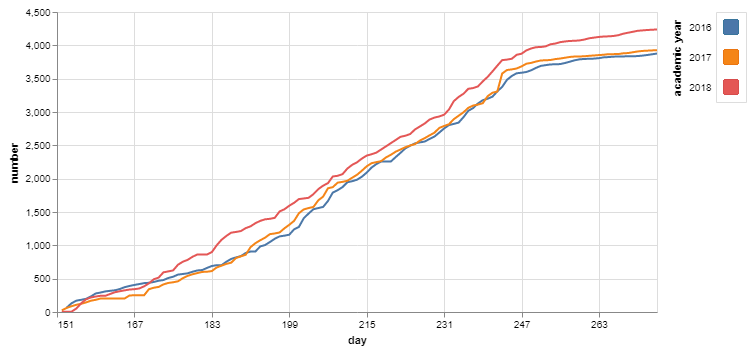

In [4]:
df_enroll = smp.compare_f_years(df.query(qry), 
                                'STATUS_DATE', 
                                'ACADEMIC_YEAR', 
                                [2016, 2017, 2018], 
                                151, 276, unit='D',).cumsum()
df_enroll.index.name = 'day'
chrt.generate_chart(df_enroll, 'number', 'academic year', mark='line', unit='D')

### Processing time in 2018 of first year enrollments by origin of the student
Let's find out what the distribution of processing time is for first year enrollments by origin. First, we calculate the processing time by subtracting the *REQUEST_DATE* from the *STATUS_DATE* and casting it in number of days. Then we add a column to our DataFrame that bins this data using the `quick_bin` function from the **tables** module. With this new column we create another crosstab and plot it a bar chart. 

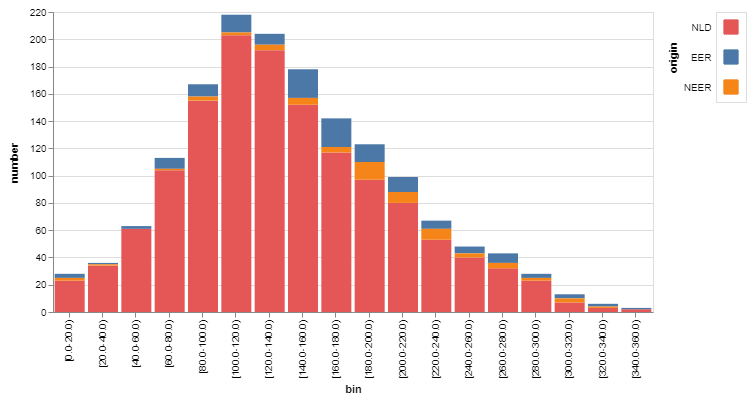

In [5]:
qry = """ACADEMIC_YEAR == 2018 & REENROLLMENT == 'no' & STATUS == 'active'"""
df['PROCESSING_TIME'] = df['STATUS_DATE'] - df['REQUEST_DATE']
df['PROCESSING_TIME']  = df['PROCESSING_TIME'].astype('timedelta64[D]')
df = tbl.quick_bin(df, 'PROCESSING_TIME', 20, bin_col='BIN', bin_str=True)
df_bin = tbl.crosstab_f(df.query(qry), 'BIN', 'ORIGIN', totals_col=False, totals_row=False)

var_order = df.ORIGIN.cat.categories.tolist()
chrt.generate_bin_chart(df_bin, 'number', 'origin', var_order=var_order)

In [6]:
df_bin

ORIGIN,NLD,EER,NEER
bin,,,
[0.0-20.0),23,3,2
[20.0-40.0),34,1,1
[40.0-60.0),61,2,0
[60.0-80.0),104,8,1
[80.0-100.0),155,9,3
[100.0-120.0),203,13,2
[120.0-140.0),192,8,4
[140.0-160.0),152,21,5
[160.0-180.0),117,21,4
